In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/QVI_data.csv')

In [3]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :

- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present
throughout the pre-trial period.

In [4]:
data['YEAR_MONTH'] = [''.join(x.split('-')[0:2]) for x in data.DATE]
data['YEAR_MONTH'] = pd.to_numeric(data['YEAR_MONTH'])

In [5]:
data.describe()

,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE,YEAR_MONTH
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512,201856.055163
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148,47.035278
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000,201807.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000,201809.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000,201812.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000,201903.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000,201906.000000


Next, we define the measure calculations to use during the analysis. <br>
For each store and month calculate:

- total sales
- number of customers
- transactions per customer
- chips per transaction
- the average price per unit.

In [10]:
# total sales

total_sales = data.groupby(['STORE_NBR', 'YEAR_MONTH'])['TOT_SALES'].sum().reset_index()
total_sales.head()

,STORE_NBR,YEAR_MONTH,TOT_SALES
0,1,201807,206.9
1,1,201808,176.1
2,1,201809,278.8
3,1,201810,188.1
4,1,201811,192.6


In [11]:
# number of customers

n_customers = data.groupby(['STORE_NBR', 'YEAR_MONTH'])['LYLTY_CARD_NBR'].nunique().reset_index()
n_customers.columns = ['STORE_NBR', 'YEAR_MONTH', 'N_CUST']
n_customers.head()

,STORE_NBR,YEAR_MONTH,N_CUST
0,1,201807,49
1,1,201808,42
2,1,201809,59
3,1,201810,44
4,1,201811,46


In [12]:
# transactions per customer

trans_per_cust = data.groupby(['STORE_NBR', 'YEAR_MONTH'])['TXN_ID'].nunique().reset_index()
trans_per_cust['TRANS_PER_CUST'] = trans_per_cust['TXN_ID'] / n_customers['N_CUST']
trans_per_cust.head()

,STORE_NBR,YEAR_MONTH,TXN_ID,TRANS_PER_CUST
0,1,201807,52,1.061224
1,1,201808,43,1.023810
2,1,201809,62,1.050847
3,1,201810,45,1.022727
4,1,201811,47,1.021739


In [13]:
# chips per transaction

chips_per_trans = data.groupby(['STORE_NBR', 'YEAR_MONTH'])['PROD_QTY'].sum().reset_index()
chips_per_trans['CHIPS_PER_TRANS'] = chips_per_trans['PROD_QTY'] / trans_per_cust['TXN_ID']
chips_per_trans.head()

,STORE_NBR,YEAR_MONTH,PROD_QTY,CHIPS_PER_TRANS
0,1,201807,62,1.192308
1,1,201808,54,1.255814
2,1,201809,75,1.209677
3,1,201810,58,1.288889
4,1,201811,57,1.212766


In [14]:
# average price per unit

avg_price = pd.DataFrame(total_sales['TOT_SALES'] / chips_per_trans['PROD_QTY'])
avg_price.columns = ['AVG_PRICE']

In [15]:
measure_OverTime = pd.concat([total_sales, 
                             n_customers['N_CUST'], 
                             trans_per_cust['TRANS_PER_CUST'], 
                             chips_per_trans['CHIPS_PER_TRANS'],
                             avg_price['AVG_PRICE']], axis = 1)

In [16]:
measure_OverTime.head()

,STORE_NBR,YEAR_MONTH,TOT_SALES,N_CUST,TRANS_PER_CUST,CHIPS_PER_TRANS,AVG_PRICE
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [17]:
measure_OverTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEAR_MONTH       3169 non-null   int64  
 2   TOT_SALES        3169 non-null   float64
 3   N_CUST           3169 non-null   int64  
 4   TRANS_PER_CUST   3169 non-null   float64
 5   CHIPS_PER_TRANS  3169 non-null   float64
 6   AVG_PRICE        3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


In [18]:
# Filter to the pre-trial period and stores with full observation periods

a = pd.pivot_table(data, index = 'STORE_NBR', 
                   columns = 'YEAR_MONTH', 
                   values = 'TXN_ID', 
                   aggfunc = 'count')

a

YEAR_MONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [19]:
null_store = a[a.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [20]:
stores_full = measure_OverTime[~measure_OverTime['STORE_NBR'].isin(null_store)]

In [21]:
print(len(stores_full))

3120


In [22]:
preTrial_measures = stores_full.loc[stores_full['YEAR_MONTH'] < 201902, :]

In [23]:
print(len(preTrial_measures))

1820


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

In [24]:
# Create a function to calculate correlation for a measure, looping through each control store

def calculateCorrelation(inputTable, metric, trial_store):
    
    """
    inputTable: DataFrame, a metric table with potential comparison stores
    metric: str, store metric used to calculate correlation on
    trail_store: int, store number of the trial store
    
    """
    
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    
    for i in storeNumbers:
        
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 
                                'Store2': i, 
                                'Correlation': b.corr(a)}, 
                                 ignore_index = True)
        
    return output

In [25]:
# Create a function to calculate a standardised magnitude distance for a measure,
# looping through each control store

def calculateMagnitudeDistance(inputTable, metric, trial_store):
    
    """
    inputTable: DataFrame, a metric table with potential comparison stores
    metric: str, store metric used to calculate correlation on
    trail_store: int, store number of the trial store
    
    """
    
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    
    for i in storeNumbers:
        
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a - b)
        d = np.mean(1 - (c - min(c)) / (max(c) - min(c)))
        output = output.append({'Store1': trial_store, 
                                'Store2': i, 
                                'Magnitude': d}, 
                                 ignore_index = True)
    return output

Now let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

## Find control store for store number 77

In [26]:
# calculate correlations against store 77 using total sales and number of customers

corr_nSales = calculateCorrelation(preTrial_measures, 'TOT_SALES', 77)
corr_nCustomers = calculateCorrelation(preTrial_measures, 'N_CUST', 77)

In [27]:
# calculate magnitude distance against store 77 using total sales and number of customers

magnitude_nSales = calculateMagnitudeDistance(preTrial_measures, 'TOT_SALES', 77)
magnitude_nCustomers = calculateMagnitudeDistance(preTrial_measures, 'N_CUST', 77)

In [28]:
corr_nSales.head()

,Store1,Store2,Correlation
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652


In [29]:
magnitude_nSales.head()

,Store1,Store2,Magnitude
0,77.0,1.0,0.408163
1,77.0,2.0,0.590119
2,77.0,3.0,0.522914
3,77.0,4.0,0.644934
4,77.0,5.0,0.516320


We'll need to combine the all the scores calculated using our function to create a composite score to rank on.


Let's take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [30]:
# Create a combined score composed of correlation and magnitude, 
# by first merging the correlations table with the magnitude table

def combined_score(correlation, magnitude, corr_weight):
    
    #magnitude.drop(columns = 'Store1', inplace = True)
    output = pd.merge(correlation, magnitude, how = 'left', on = 'Store2')

    output['score'] = corr_weight * output['Correlation'] + (1 - corr_weight) * output['Magnitude']
    
    return output

In [31]:
score_nSales = combined_score(corr_nSales, magnitude_nSales, 0.5)

score_nSales.head() 

,Store1_x,Store2,Correlation,Store1_y,Magnitude,score
0,77.0,1.0,0.075218,77.0,0.408163,0.241691
1,77.0,2.0,-0.263079,77.0,0.590119,0.163520
2,77.0,3.0,0.806644,77.0,0.522914,0.664779
3,77.0,4.0,-0.263300,77.0,0.644934,0.190817
4,77.0,5.0,-0.110652,77.0,0.516320,0.202834


In [32]:
score_nCustomers = combined_score(corr_nCustomers, magnitude_nCustomers, 0.5)

score_nCustomers.tail()

,Store1_x,Store2,Correlation,Store1_y,Magnitude,score
255,77.0,268.0,0.369517,77.0,0.571429,0.470473
256,77.0,269.0,-0.474293,77.0,0.484472,0.005090
257,77.0,270.0,-0.131259,77.0,0.536680,0.202710
258,77.0,271.0,0.019629,77.0,0.328571,0.174100
259,77.0,272.0,0.223217,77.0,0.545455,0.384336


Now we have a score for each of total number of sales and number of customers. <br>
Let's combine the two via a simple average.

In [33]:
# Combine scores across the drivers by first merging our sales scores 
# and customer scores into a single table

def final_score(metric_1, metric_2):
    
    output = pd.concat([metric_1['Store2'], 
                        metric_1['score'], 
                        metric_2['score']], axis = 1)
    output.columns = ['Store2', 'corr_score', 'mag_score']
    output['final_score'] = 0.5 * output['corr_score'] + 0.5 * output['mag_score']
    
    output.sort_values(by = 'final_score', ascending = False, inplace = True)
    
    return output

In [34]:
score_Control = final_score(score_nSales, score_nCustomers)

score_Control.head()

,Store2,corr_score,mag_score,final_score
221,233.0,0.697290,0.816607,0.756949
67,71.0,0.789497,0.663123,0.726310
79,84.0,0.656972,0.715000,0.685986
111,119.0,0.636046,0.729729,0.682887
108,115.0,0.708347,0.645155,0.676751


In [35]:
control_store = score_Control['Store2'].iloc[0]
trial_store = 77

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.

In [36]:
# We'll look at total sales first

def past_period(df, trial_store, control_store):
    
    past = df.copy()
    
    store_type = []
    
    for i in past['STORE_NBR']:
    
        if i == trial_store:
            store_type.append('Trial Store')

        elif i == control_store:
            store_type.append('Control Store')

        else:
            store_type.append('Other Stores')

    past['store_type'] = store_type

    past = past.loc[past['YEAR_MONTH'] < 201903, :]
    
    past['Transaction_Month'] = pd.to_datetime(
        past['YEAR_MONTH'].astype(str), format = '%Y%m')
    
    return past

In [37]:
past_period_77 = past_period(measure_OverTime, 77, 233)

past_period_77.head()

,STORE_NBR,YEAR_MONTH,TOT_SALES,N_CUST,TRANS_PER_CUST,CHIPS_PER_TRANS,AVG_PRICE,store_type,Transaction_Month
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


In [38]:
past_period_77['store_type'].value_counts()

Other Stores     2096
Trial Store         8
Control Store       8
Name: store_type, dtype: int64

In [39]:
past_period_77['YEAR_MONTH'].value_counts()

201807    266
201810    265
201811    264
201809    264
201902    264
201901    263
201812    263
201808    263
Name: YEAR_MONTH, dtype: int64

In [40]:
pastSales_plot = pd.pivot_table(past_period_77, index = 'Transaction_Month', 
                   columns = 'store_type', 
                   values = 'TOT_SALES', 
                   aggfunc = np.mean)

In [41]:
pastSales_plot

store_type,Control Store,Other Stores,Trial Store
Transaction_Month,,,
2018-07-01,290.7,623.817424,296.8
2018-08-01,285.9,603.600192,255.5
2018-09-01,228.6,610.947328,225.2
2018-10-01,185.7,623.671103,204.5
2018-11-01,211.6,609.835115,245.3
2018-12-01,279.8,641.250192,267.3
2019-01-01,177.5,621.687356,204.4
2019-02-01,244.0,573.229008,235.0


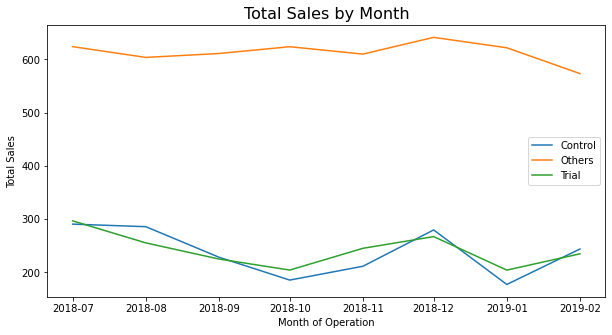

In [42]:
# Plot total sales by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(pastSales_plot)
plt.title('Total Sales by Month', fontsize = 16)
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control', 'Others', 'Trial'], loc = 5)

In [43]:
# We'll look at number of customers next

pastCust_plot = pd.pivot_table(past_period_77, index = 'Transaction_Month', 
                   columns = 'store_type', 
                   values = 'N_CUST', 
                   aggfunc = np.mean)

In [44]:
pastCust_plot

store_type,Control Store,Other Stores,Trial Store
Transaction_Month,,,
2018-07-01,51.0,70.750000,51.0
2018-08-01,48.0,71.352490,47.0
2018-09-01,42.0,69.110687,42.0
2018-10-01,35.0,70.334601,37.0
2018-11-01,40.0,69.534351,41.0
2018-12-01,47.0,72.731801,46.0
2019-01-01,35.0,70.471264,35.0
2019-02-01,45.0,65.492366,45.0


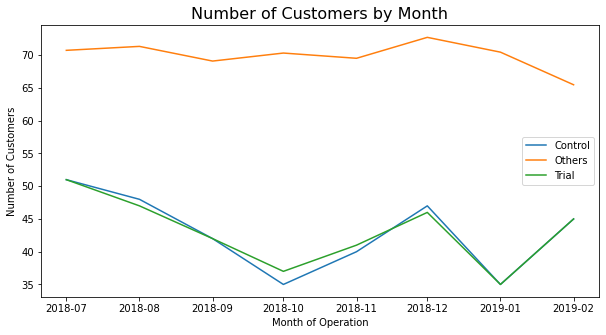

In [45]:
# Plot number of customers by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(pastCust_plot)
plt.title('Number of Customers by Month', fontsize = 16)
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control', 'Others', 'Trial'], loc = 5)

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [46]:
def scaling_factor(df, trial_store, control_store, agg):
    
    trial_sum = df.loc[df['STORE_NBR'] == trial_store, agg].sum()
    control_sum = df.loc[df['STORE_NBR'] == control_store, agg].sum()
    
    result = trial_sum / control_sum
    
    return result

In [47]:
scalingFactor_Sales = scaling_factor(preTrial_measures, 77, 233, 'TOT_SALES')

scalingFactor_Sales

1.023617303289553

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [48]:
def percent_diff(df, trial_store, control_store, agg):
    
    scaled_control = df.loc[df['STORE_NBR'] == control_store]
    scaled_control['scaled_agg'] = scaled_control[agg] * scalingFactor_Sales
    
    percentage_diff = scaled_control[['YEAR_MONTH', 'scaled_agg']]
    percentage_diff.reset_index(drop = True, inplace = True)
    
    trial_agg = df.loc[df['STORE_NBR'] == trial_store, agg]
    trial_agg.reset_index(drop = True, inplace = True)
    
    percentage_diff = pd.concat([percentage_diff, trial_agg], axis = 1)
    percentage_diff.rename(columns = {})
    
    percentage_diff['percent_diff'] = abs(
        percentage_diff['scaled_agg'] - percentage_diff[agg]) / percentage_diff['scaled_agg']
    
    return percentage_diff
    

In [49]:
# Scale pre-trial control sales to match pre-trial trial store sales

sales_diff = percent_diff(measure_OverTime, 77, 233, 'TOT_SALES')

sales_diff

,YEAR_MONTH,scaled_agg,TOT_SALES,percent_diff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [50]:
sigma = np.std(sales_diff.loc[sales_diff['YEAR_MONTH'] < 201902, 'percent_diff'])

sigma

0.046236161851401905

In [51]:
# Note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom

dof = 7

We will test with a null hypothesis of there being 0 difference between trial and control stores.

Calculate the t-values for the trial months. After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

In [52]:
sales_diff['tValue'] = (sales_diff['percent_diff'] - 0) / sigma

print('tValue for trial period Feb to Apr 2019')
sales_diff.loc[
    (sales_diff['YEAR_MONTH'] > 201901) & (sales_diff['YEAR_MONTH'] < 201905),
    'tValue']

tValue for trial period Feb to Apr 2019


7     1.278363
8     7.927151
9    13.476023
Name: tValue, dtype: float64

In [53]:
from scipy.stats import t

# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [54]:
def trial_assessment(df, trial_store, control_store, agg):
    
    scaled_control = df.loc[df['STORE_NBR'] == control_store]
    scaled_control['scaled_agg'] = scaled_control[agg] * scalingFactor_Sales
    scaled_control['Transaction_Month'] = pd.to_datetime(
        scaled_control['YEAR_MONTH'].astype(str), 
        format = '%Y%m')
    
    control = scaled_control.loc[:, ['Transaction_Month', 'scaled_agg']]
    control.set_index('Transaction_Month', inplace = True)
    
    df['Transaction_Month'] = pd.to_datetime(
        df['YEAR_MONTH'].astype(str), 
        format = '%Y%m')
    
    trial = df.loc[
        df['STORE_NBR'] == trial_store, ['Transaction_Month', agg]]
    trial.set_index('Transaction_Month', inplace = True)
    
    control['Control 5% Confidence Interval'] = control['scaled_agg'] * (1 - sigma * 2)
    control['Control 95% Confidence Interval'] = control['scaled_agg'] * (1 + sigma * 2)
    
    combined = pd.merge(control, trial, left_index = True, right_index = True)
    
    return combined

In [55]:
sales_assessment = trial_assessment(measure_OverTime, 77, 233, 'TOT_SALES')

sales_assessment

,scaled_agg,Control 5% Confidence Interval,Control 95% Confidence Interval,TOT_SALES
Transaction_Month,,,,
2018-07-01,297.565550,270.048972,325.082128,296.8
2018-08-01,292.652187,265.589959,319.714415,255.5
2018-09-01,233.998916,212.360492,255.637339,225.2
2018-10-01,190.085733,172.508064,207.663403,204.5
2018-11-01,216.597421,196.568155,236.626688,245.3
2018-12-01,286.408121,259.923297,312.892946,267.3
2019-01-01,181.692071,164.890583,198.493559,204.4
2019-02-01,249.762622,226.666492,272.858752,235.0
2019-03-01,203.802205,184.956142,222.648269,278.5


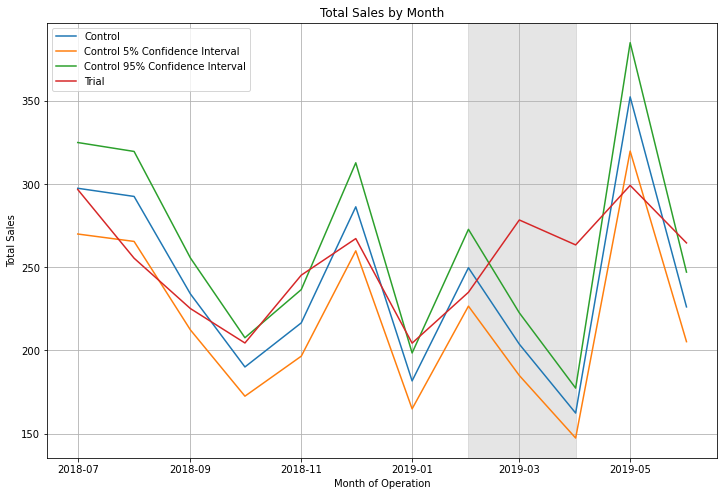

In [56]:
import matplotlib.dates as mdates

plt.figure(figsize = (12, 8))
plt.plot(sales_assessment)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial'])

# Set new y-axis limit
# plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

Let's have a look at assessing this for number of customers as well.

In [57]:
scalingFactor_Cust = scaling_factor(preTrial_measures, 77, 233, 'N_CUST')

scalingFactor_Cust

1.0033557046979866

In [58]:
cust_diff = percent_diff(measure_OverTime, 77, 233, 'N_CUST')

cust_diff

,YEAR_MONTH,scaled_agg,N_CUST,percent_diff
0,201807,52.204482,51,0.023072
1,201808,49.133631,47,0.043425
2,201809,42.991927,42,0.023072
3,201810,35.826606,37,0.032752
4,201811,40.944692,41,0.001351
5,201812,48.110013,46,0.043858
6,201901,35.826606,35,0.023072
7,201902,46.062779,45,0.023072
8,201903,40.944692,50,0.221160
9,201904,30.708519,47,0.530520


As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [59]:
sigma = np.std(cust_diff.loc[cust_diff['YEAR_MONTH'] < 201902, 'percent_diff'])

sigma

0.013579692455319082

In [60]:
cust_assessment = trial_assessment(measure_OverTime, 77, 233, 'N_CUST')

cust_assessment

,scaled_agg,Control 5% Confidence Interval,Control 95% Confidence Interval,N_CUST
Transaction_Month,,,,
2018-07-01,52.204482,50.786641,53.622324,51
2018-08-01,49.133631,47.799191,50.468070,47
2018-09-01,42.991927,41.824292,44.159561,42
2018-10-01,35.826606,34.853577,36.799634,37
2018-11-01,40.944692,39.832659,42.056725,41
2018-12-01,48.110013,46.803375,49.416652,46
2019-01-01,35.826606,34.853577,36.799634,35
2019-02-01,46.062779,44.811742,47.313815,45
2019-03-01,40.944692,39.832659,42.056725,50


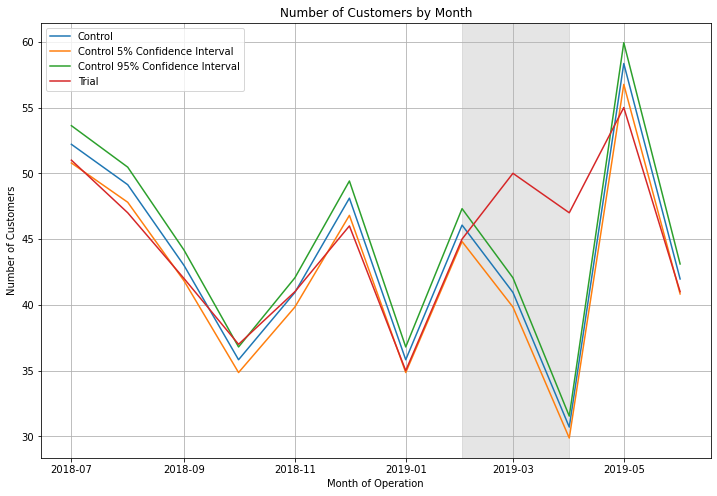

In [61]:
plt.figure(figsize = (12, 8))
plt.plot(cust_assessment)

# Set graph title and axis title
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')

# Set legend
plt.legend(['Control', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial'])

# Set new y-axis limit
# plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Find control store for store number 86

In [62]:
# calculate correlations against store 77 using total sales and number of customers

corr_nSales = calculateCorrelation(preTrial_measures, 'TOT_SALES', 86)
corr_nCustomers = calculateCorrelation(preTrial_measures, 'N_CUST', 86)

In [63]:
# calculate magnitude distance against store 77 using total sales and number of customers

magnitude_nSales = calculateMagnitudeDistance(preTrial_measures, 'TOT_SALES', 86)
magnitude_nCustomers = calculateMagnitudeDistance(preTrial_measures, 'N_CUST', 86)

In [64]:
corr_nSales.head()

,Store1,Store2,Correlation
0,86.0,1.0,0.445632
1,86.0,2.0,-0.403835
2,86.0,3.0,-0.261284
3,86.0,4.0,-0.039035
4,86.0,5.0,0.235159


In [65]:
magnitude_nSales.head()

,Store1,Store2,Magnitude
0,86.0,1.0,0.488334
1,86.0,2.0,0.321131
2,86.0,3.0,0.507515
3,86.0,4.0,0.635654
4,86.0,5.0,0.579835


We'll need to combine the all the scores calculated using our function to create a composite score to rank on.


Let's take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [66]:
score_nSales = combined_score(corr_nSales, magnitude_nSales, 0.5)

score_nSales.head() 

,Store1_x,Store2,Correlation,Store1_y,Magnitude,score
0,86.0,1.0,0.445632,86.0,0.488334,0.466983
1,86.0,2.0,-0.403835,86.0,0.321131,-0.041352
2,86.0,3.0,-0.261284,86.0,0.507515,0.123116
3,86.0,4.0,-0.039035,86.0,0.635654,0.298309
4,86.0,5.0,0.235159,86.0,0.579835,0.407497


In [67]:
score_nCustomers = combined_score(corr_nCustomers, magnitude_nCustomers, 0.5)

score_nCustomers.tail()

,Store1_x,Store2,Correlation,Store1_y,Magnitude,score
255,86.0,268.0,-0.034273,86.0,0.566327,0.266027
256,86.0,269.0,-0.098587,86.0,0.581633,0.241523
257,86.0,270.0,-0.767267,86.0,0.650794,-0.058237
258,86.0,271.0,0.267393,86.0,0.598214,0.432804
259,86.0,272.0,-0.353815,86.0,0.633540,0.139863


Now we have a score for each of total number of sales and number of customers. <br>
Let's combine the two via a simple average.

In [68]:
score_Control = final_score(score_nSales, score_nCustomers)

score_Control.head()

,Store2,corr_score,mag_score,final_score
147,155.0,0.808106,0.733343,0.770724
102,109.0,0.697120,0.742532,0.719826
107,114.0,0.631393,0.663384,0.647389
213,225.0,0.601841,0.684356,0.643099
130,138.0,0.593296,0.660565,0.626930


In [69]:
control_store = score_Control['Store2'].iloc[0]
trial_store = 86

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.

In [70]:
past_period_86 = past_period(measure_OverTime, 86, 155)

past_period_86.head()

,STORE_NBR,YEAR_MONTH,TOT_SALES,N_CUST,TRANS_PER_CUST,CHIPS_PER_TRANS,AVG_PRICE,Transaction_Month,store_type
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01,Other Stores
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01,Other Stores
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01,Other Stores
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01,Other Stores
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01,Other Stores


In [71]:
pastSales_plot = pd.pivot_table(past_period_86, index = 'Transaction_Month', 
                   columns = 'store_type', 
                   values = 'TOT_SALES', 
                   aggfunc = np.mean)

In [72]:
pastSales_plot

store_type,Control Store,Other Stores,Trial Store
Transaction_Month,,,
2018-07-01,924.6,619.160985,892.20
2018-08-01,782.7,599.748276,764.05
2018-09-01,1014.4,605.316794,914.60
2018-10-01,963.8,617.884030,948.40
2018-11-01,898.8,604.644656,918.00
2018-12-01,849.8,636.867433,841.20
2019-01-01,874.6,616.575862,841.40
2019-02-01,891.2,568.170229,913.20


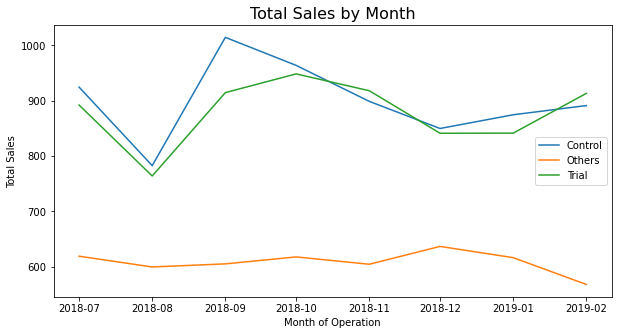

In [73]:
# Plot total sales by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(pastSales_plot)
plt.title('Total Sales by Month', fontsize = 16)
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control', 'Others', 'Trial'], loc = 5)

In [74]:
# We'll look at number of customers next

pastCust_plot = pd.pivot_table(past_period_86, index = 'Transaction_Month', 
                   columns = 'store_type', 
                   values = 'N_CUST', 
                   aggfunc = np.mean)

In [75]:
pastCust_plot

store_type,Control Store,Other Stores,Trial Store
Transaction_Month,,,
2018-07-01,101.0,70.378788,99.0
2018-08-01,91.0,71.007663,94.0
2018-09-01,103.0,68.645038,103.0
2018-10-01,108.0,69.783270,109.0
2018-11-01,101.0,69.076336,100.0
2018-12-01,97.0,72.340996,98.0
2019-01-01,96.0,70.011494,94.0
2019-02-01,95.0,65.064885,107.0


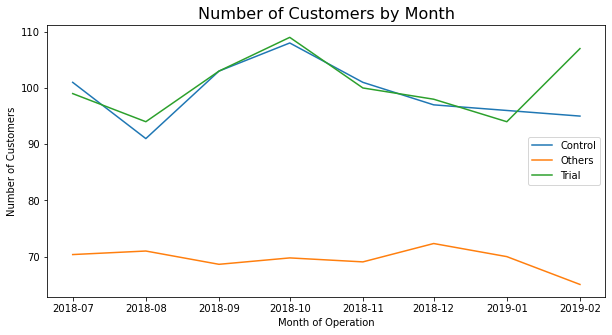

In [76]:
# Plot number of customers by month for all 3 types of stores

plt.figure(figsize = (10, 5))
plt.plot(pastCust_plot)
plt.title('Number of Customers by Month', fontsize = 16)
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control', 'Others', 'Trial'], loc = 5)

The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [77]:
scalingFactor_Sales = scaling_factor(preTrial_measures, 86, 155, 'TOT_SALES')

scalingFactor_Sales

0.9700651481287746

Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [78]:
# Scale pre-trial control sales to match pre-trial trial store sales

sales_diff = percent_diff(measure_OverTime, 86, 155, 'TOT_SALES')

sales_diff

,YEAR_MONTH,scaled_agg,TOT_SALES,percent_diff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561
3,201810,934.948790,948.40,0.014387
4,201811,871.894555,918.00,0.052880
5,201812,824.361363,841.20,0.020426
6,201901,848.418979,841.40,0.008273
7,201902,864.522060,913.20,0.056306
8,201903,780.320405,1026.80,0.315870
9,201904,819.317024,848.20,0.035253


As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [79]:
sigma = np.std(sales_diff.loc[sales_diff['YEAR_MONTH'] < 201902, 'percent_diff'])

sigma

0.023917592809524945

In [80]:
# Note that there are 8 months in the pre-trial period hence 8 - 1 = 7 degrees of freedom

dof = 7

We will test with a null hypothesis of there being 0 difference between trial and control stores.

Calculate the t-values for the trial months. After that, find the 95th percentile of the t distribution with the appropriate degrees of freedom to check whether the hypothesis is statistically significant.

In [81]:
sales_diff['tValue'] = (sales_diff['percent_diff'] - 0) / sigma

print('tValue for trial period Feb to Apr 2019')
sales_diff.loc[
    (sales_diff['YEAR_MONTH'] > 201901) & (sales_diff['YEAR_MONTH'] < 201905),
    'tValue']

tValue for trial period Feb to Apr 2019


7     2.354174
8    13.206585
9     1.473915
Name: tValue, dtype: float64

In [82]:
from scipy.stats import t

# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

1.8945786050613054

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [83]:
sales_assessment = trial_assessment(measure_OverTime, 86, 155, 'TOT_SALES')

sales_assessment

,scaled_agg,Control 5% Confidence Interval,Control 95% Confidence Interval,TOT_SALES
Transaction_Month,,,,
2018-07-01,896.922236,854.017794,939.826678,892.20
2018-08-01,759.269991,722.950170,795.589812,764.05
2018-09-01,984.034086,936.962633,1031.105539,914.60
2018-10-01,934.948790,890.225341,979.672239,948.40
2018-11-01,871.894555,830.187317,913.601793,918.00
2018-12-01,824.361363,784.927884,863.794842,841.20
2019-01-01,848.418979,807.834699,889.003258,841.40
2019-02-01,864.522060,823.167487,905.876633,913.20
2019-03-01,780.320405,742.993634,817.647177,1026.80


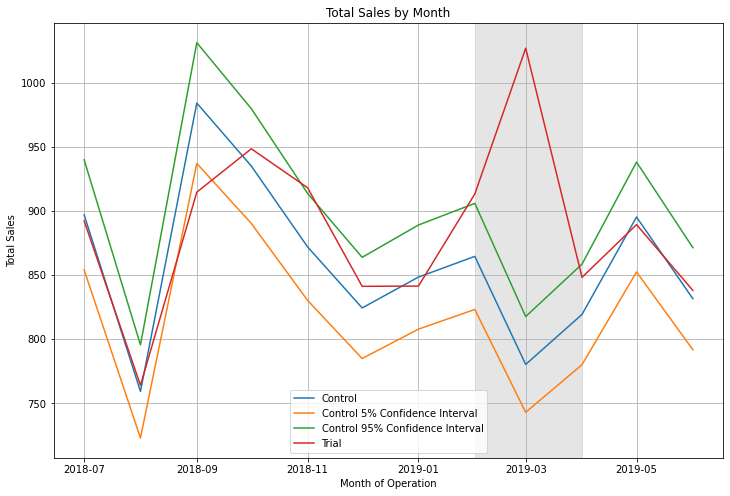

In [84]:
plt.figure(figsize = (12, 8))
plt.plot(sales_assessment)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial'])

# Set new y-axis limit
# plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

Let's have a look at assessing this for number of customers as well.

In [85]:
scalingFactor_Cust = scaling_factor(preTrial_measures, 86, 155, 'N_CUST')

scalingFactor_Cust

1.0

In [86]:
cust_diff = percent_diff(measure_OverTime, 86, 155, 'N_CUST')

cust_diff

,YEAR_MONTH,scaled_agg,N_CUST,percent_diff
0,201807,97.976580,99,0.010446
1,201808,88.275928,94,0.064843
2,201809,99.916710,103,0.030859
3,201810,104.767036,109,0.040404
4,201811,97.976580,100,0.020652
5,201812,94.096319,98,0.041486
6,201901,93.126254,94,0.009382
7,201902,92.156189,107,0.161072
8,201903,91.186124,115,0.261157
9,201904,96.036450,105,0.093335


As our null hypothesis is that the trial period is the same as the pre-trial period, let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [87]:
sigma = np.std(cust_diff.loc[cust_diff['YEAR_MONTH'] < 201902, 'percent_diff'])

sigma

0.01828532272006243

In [88]:
cust_assessment = trial_assessment(measure_OverTime, 86, 155, 'N_CUST')

cust_assessment

,scaled_agg,Control 5% Confidence Interval,Control 95% Confidence Interval,N_CUST
Transaction_Month,,,,
2018-07-01,97.976580,94.393513,101.559647,99
2018-08-01,88.275928,85.047621,91.504236,94
2018-09-01,99.916710,96.262692,103.570729,103
2018-10-01,104.767036,100.935638,108.598434,109
2018-11-01,97.976580,94.393513,101.559647,100
2018-12-01,94.096319,90.655156,97.537483,98
2019-01-01,93.126254,89.720567,96.531941,94
2019-02-01,92.156189,88.785978,95.526400,107
2019-03-01,91.186124,87.851389,94.520859,115


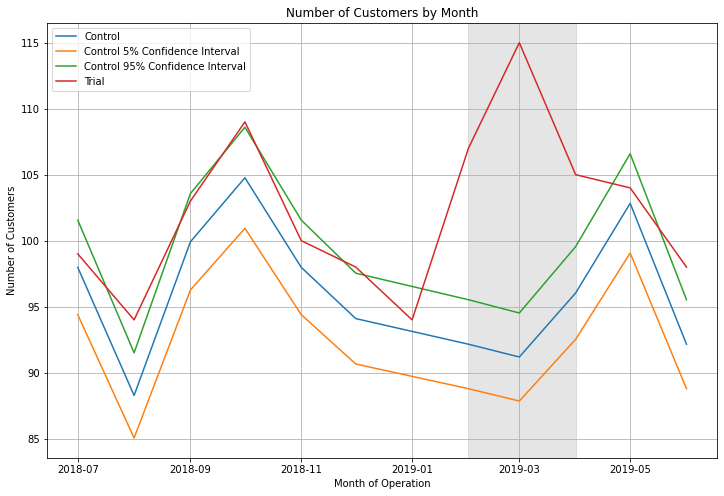

In [89]:
plt.figure(figsize = (12, 8))
plt.plot(cust_assessment)

# Set graph title and axis title
plt.title('Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')

# Set legend
plt.legend(['Control', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial'])

# Set new y-axis limit
# plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. <br>
We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results.

## Find control store for store number 88